In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import gym

from gym import spaces

# import axelrod

In [2]:
import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.ppo import DEFAULT_CONFIG as DEFAULT_CONFIG_PPO

from ray.rllib.agents.dqn import DQNTrainer, DEFAULT_CONFIG 
from ray.rllib.agents.dqn import  DEFAULT_CONFIG as DEFAULT_CONFIG_DQN


from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
from ray import tune

ray.init(ignore_reinit_error=True, log_to_driver=False)

/home/peter/.local/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(
2021-07-30 20:45:51,819	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.21',
 'raylet_ip_address': '192.168.1.21',
 'redis_address': '192.168.1.21:6379',
 'object_store_address': '/tmp/ray/session_2021-07-30_20-45-50_536289_66576/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-30_20-45-50_536289_66576/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-30_20-45-50_536289_66576',
 'metrics_export_port': 52646,
 'node_id': '4ffe0332e659415059b4a5ff4ede5793585f092b9628baa1b4c5e050'}

In [3]:
DEFAULT_CONFIG_DQN

{'num_workers': 0,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 4,
 'batch_mode': 'truncate_episodes',
 'train_batch_size': 32,
 'model': {'_use_default_native_models': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,
  'attention_use_n_prev_actions': 0,
  'attention_use_n_prev_rewards': 0

In [4]:
class MatrixGame():
    
    def __init__(self, RPST=(3,1,0,5)):
        
        self.RPST = RPST
        
        self.payoff_mat = np.empty((2,2), dtype=np.object)
        
        self.payoff_mat[0, 0] = (RPST[0], RPST[0])
        self.payoff_mat[1, 1] = (RPST[1], RPST[1])
        self.payoff_mat[0, 1] = (RPST[2], RPST[3])
        self.payoff_mat[1, 0] = (RPST[3], RPST[2])
        
    def play(self, a_row, a_col):
        # for ease of things 0 is coooperate
#                            1 is defect
        
        
#         if a_row == 'c':
#             row = 0
#         else:
#             row = 1
            
#         if a_col == 'c':
#             col = 0
#         else:
#             col = 1
            
        return self.payoff_mat[a_row, a_col]
        

In [5]:
class TitForTatPlayer():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        
    def play(self):
        
        return self.opponents_move
    
    def update(self, opponents_move):
        self.opponents_move = opponents_move
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
 

In [6]:
class TitForTatThenDefectPlayer():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self, n_defect_turn=50):
        
        self.count = 0
        self.opponents_move = 0
        self.n_defect_turn = n_defect_turn
        
    def play(self):
        
        if self.count < self.n_defect_turn:
            return self.opponents_move
        else:
            return 1
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
 

In [7]:
np.random.randint(2, dtype=np.bool)

False

In [8]:
class TitForTatOrRandom():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        
    def play(self):
        
        if self.is_random:
            return np.random.randint(2)
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)

 

In [9]:
class TitForTatOrDefect():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        
    def play(self):
        
        if self.is_random:
            return 1
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)

 

In [10]:
class TitForTatThenDefect():
    """Starts by cooperating, and then always plays the opponents previous move
    
    """
    
    def __init__(self, min_defect_turn = 50, max_defect_turn=100):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        self.min_defect_turn = min_defect_turn
        self.max_defect_turn = max_defect_turn
        
        self.defect_turn = np.random.randint(low=self.min_defect_turn, high=self.max_defect_turn)
        
    def play(self):
        
        if self.count > self.defect_turn:
            return 1
        else:
            return self.opponents_move
    
    def update(self, opponents_move):
        
        self.opponents_move = opponents_move
        self.count += 1
        
        
    def reset(self):
        
        self.count = 0
        self.opponents_move = 0
        self.is_random = np.random.randint(2, dtype=np.bool)
        self.defect_turn = np.random.randint(low=self.min_defect_turn, high=self.max_defect_turn)

 

In [11]:
for ii in range(20):
    print(np.random.randint(low=2,high=5))

4
3
2
3
4
3
4
4
2
4
4
2
4
2
4
4
3
4
2
4


In [12]:
class GrudgePlayer():
    """Starts by cooperating, but defects forever if opponent defects
    
    """
    
    def __init__(self):
        
        self.count = 0
#         self.opponents_move = 0
        self.grudging = False # has the opponent played defect
        
    def play(self):
        
        if self.grudging:
            return 1
        
        else:
            return 0
    
    def update(self, opponents_move):
#         self.opponents_move = opponents_move
        if opponents_move == 1:
            self.grudging = True
        
    def reset(self):
        
        self.count = 0
        self.grudging = False  

In [13]:
class RandomPlayer():
    """Cooperates a with a fixed probability
    
    """
    
    def __init__(self, P_coop=0.5):
        
        self.count = 0
        self.P_coop = P_coop
        
        assert self.P_coop <= 1.
    
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0


In [14]:
class RandomProbPlayer():
    """Cooperates a with a probability P_coop,
    P_coop is chosen randomly each round
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.P_coop = np.random.rand()
            
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0
        self.P_coop = np.random.rand()



In [15]:
class CooperateOrDefectPlayer():
    """Either always cooperates or always defects each round
    
    """
    
    def __init__(self):
        
        self.count = 0
        self.P_coop = np.random.randint(2)
            
        
    def play(self):
        
        if np.random.rand() < self.P_coop:
            return 0 
        
        else:
            return 1
        
    
    def update(self, opponents_move):
        pass
        
    def reset(self):
        
        self.count = 0
        self.P_coop = np.random.randint(2)



In [16]:
class CooperatePlayer(RandomPlayer):
    """ Always cooperates
    """
    def __init__(self):
        super().__init__(P_coop=1.)

In [17]:
class DefectPlayer(RandomPlayer):
    """Always defects
    """
     
    def __init__(self):
        super().__init__(P_coop=0.)

In [18]:
class MatrixGameEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.player2 = player2
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.history[0, action, self._counter] = 1
        self.history[1, action2, self._counter] = 1
        
        self.state = self.history_to_state(self.history)
        
        self._counter += 1
        done = self._counter >= self.history_n 
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [19]:
class MatrixGameRollingHistoryEnv(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), history_n=10, game_length=100,player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.history_n = history_n
        self.history = np.zeros((2,2,self.history_n))
        self._counter = 0
        self._setup_spaces()
#         self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
#         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrDefect()
        self.player2 = player2
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(self.history_n * 4,))
        
    def history_to_state(self, history=None):
        
        if history is None:
            history = self.history
            
        state = history.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.history[0, action, self._counter] = 1
        self.history[1, action2, self._counter] = 1
        
        self.state = self.history_to_state(self.history)
        
        self._counter += 1
        done = self._counter >= self.history_n 
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.history = np.zeros((2,2,self.history_n))
        self.state = self.history.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [20]:
register_env('MG_env', lambda c: MatrixGameEnv(player2=TitForTatOrRandom()))

In [21]:
class MatrixGameEnv_no_history(gym.Env):
    
    def __init__(self,  RPST=(3,1,0,5), n_games=100, player2=TitForTatPlayer()):
        
        self.RPST = RPST
        self.last_moves = np.zeros((2,2))
        self._counter = 0
        self._setup_spaces()
        self.player2 = TitForTatPlayer()
#         self.player2 = GrudgePlayer()
#         self.player2 = DefectPlayer()
#         self.player2 = CooperateOrDefectPlayer()
    #         self.player2 = TitForTatThenDefectPlayer()
#         self.player2 = TitForTatOrRandom()
        self.player2 = player2
        self.n_games = n_games
        self.game = MatrixGame(RPST=(3,1,0,5))
        
        
        
    def _setup_spaces(self):
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Box(0, 1,
                                           shape=(4,))
        
    def lastmoves_to_state(self, last_moves=None):
        
        if last_moves is None:
            last_moves = self.last_moves
            
        state = last_moves.flatten()
        
        return state

    def step(self, action):
        
        assert self.action_space.contains(action)
        
        action2 = self.player2.play()
        rewards = self.game.play(action, action2)
        
        self.player2.update(action)
        self.last_moves = np.zeros((2,2))

        self.last_moves[0, action] = 1
        self.last_moves[1, action2] = 1
        
        self.state = self.lastmoves_to_state(self.last_moves)
        
        self._counter += 1
        done = self._counter >= self.n_games
        
        return self.state, rewards[0], done, {}

        
        
    def reset(self):

        self.last_moves = np.zeros((2,2))
        self.state = self.last_moves.flatten()

        self._counter = 0
        self.player2.reset()
        
        return self.state

        
        

In [22]:
register_env('MG_env', lambda c: MatrixGameEnv(player2=TitForTatOrDefect()))

In [23]:
trainer_config_dqn = DEFAULT_CONFIG_DQN.copy()
trainer_config_dqn['num_workers'] = 3
trainer_config_dqn['n_step'] = 3
trainer_config_dqn['noisy'] = True
trainer_config_dqn['v_min'] = -10.
trainer_config_dqn['v_max'] = 10.
# trainer_config_dqn['num_atoms'] = 51

# trainer_config_dqn['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
trainer_config_dqn['model']['fcnet_hiddens'] = [256,256,32,8]

trainer_config_dqn['num_cpus_per_worker'] = 0


In [24]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()
trainer_config_ppo['num_workers'] = 3
trainer_config_ppo['num_sgd_iter'] = 20
trainer_config_ppo['sgd_minibatch_size'] = 32
trainer_config_ppo['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = [20,20]

# trainer_config_ppo['lr'] =  0.001

trainer_config_ppo['num_cpus_per_worker'] = 0

In [34]:
# trainer = PPOTrainer(trainer_config_ppo, env="MG_env");
trainer = DQNTrainer(trainer_config_dqn, env="MG_env");
ep_min = []
ep_mean = []
ep_max = []

for i in range(20):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))

    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

2021-07-29 11:20:49,967	INFO trainable.py:101 -- Trainable.setup took 14.931 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-07-29 11:20:49,968	WARNING util.py:53 -- Install gputil for GPU system monitoring.


Training iteration 0...
32.0
105.33333333333333
240.0
Training iteration 1...
32.0
125.72222222222223
240.0
Training iteration 2...
32.0
149.0
240.0
Training iteration 3...
32.0
163.4102564102564
260.0
Training iteration 4...
32.0
161.89583333333334
272.0
Training iteration 5...
32.0
166.26666666666668
279.0
Training iteration 6...
32.0
172.0144927536232
280.0
Training iteration 7...
32.0
176.96153846153845
288.0
Training iteration 8...
32.0
169.37777777777777
289.0
Training iteration 9...
32.0
170.17171717171718
291.0
Training iteration 10...
49.0
181.84
297.0
Training iteration 11...
49.0
187.67
301.0
Training iteration 12...
66.0
196.94
301.0
Training iteration 13...
67.0
191.36
301.0
Training iteration 14...
69.0
191.7
301.0
Training iteration 15...
77.0
190.42
301.0
Training iteration 16...
81.0
186.08
301.0
Training iteration 17...
81.0
191.09
301.0
Training iteration 18...
85.0
193.62
301.0
Training iteration 19...
88.0
196.87
301.0


In [35]:
for i in range(50):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))
    
    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

Training iteration 0...
88.0
196.12
301.0
Training iteration 1...
88.0
195.41
301.0
Training iteration 2...
88.0
192.53
300.0
Training iteration 3...
88.0
192.16
300.0
Training iteration 4...
88.0
195.5
300.0
Training iteration 5...
82.0
192.75
293.0
Training iteration 6...
80.0
196.05
293.0
Training iteration 7...
79.0
187.16
293.0
Training iteration 8...
79.0
198.4
293.0
Training iteration 9...
79.0
196.84
293.0
Training iteration 10...
79.0
196.85
293.0
Training iteration 11...
79.0
196.7
293.0
Training iteration 12...
79.0
188.48
292.0
Training iteration 13...
79.0
190.27
292.0
Training iteration 14...
79.0
184.36
292.0
Training iteration 15...
79.0
186.22
292.0
Training iteration 16...
79.0
191.47
291.0
Training iteration 17...
79.0
199.63
292.0
Training iteration 18...
79.0
193.32
292.0
Training iteration 19...
79.0
186.74
292.0
Training iteration 20...
75.0
187.99
292.0
Training iteration 21...
74.0
191.33
293.0
Training iteration 22...
74.0
195.0
293.0
Training iteration 23...


In [29]:
50*3+1*50

200

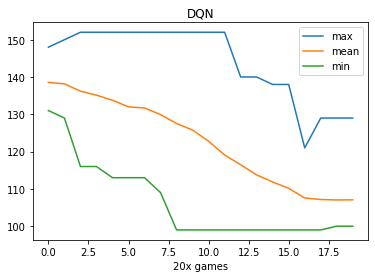

In [23]:
plt.plot(ep_max)
plt.plot(ep_mean)
plt.plot(ep_min)

plt.title('DQN')
plt.xlabel('20x games')
plt.legend(['max', 'mean', 'min'])

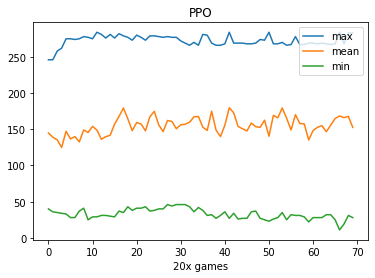

In [82]:
plt.plot(ep_max)
plt.plot(ep_mean)
plt.plot(ep_min)

plt.title('PPO')
plt.xlabel('20x games')
plt.legend(['max', 'mean', 'min'])

In [ ]:
trainer1 = PPOTrainer(trainer_config_ppo, MatrixGameEnv_no_history);
trainer2 = PPOTrainer(trainer_config_ppo, MatrixGameEnv_no_history);

# trainer = DQNTrainer(trainer_config_dqn, MatrixGameEnv_no_history);
ep_min = []
ep_mean = []
ep_max = []

for i in range(20):
    print("Training iteration {}...".format(i))
    result=trainer.train()
#     print(pretty_print(result))

    print(result['episode_reward_min'])
    print(result['episode_reward_mean'])
    print(result['episode_reward_max'])
    
    ep_min.append(result['episode_reward_min'])
    ep_mean.append(result['episode_reward_mean'])
    ep_max.append(result['episode_reward_max'])

In [41]:
state = env.reset()

done = False
cumulative_reward = 0
action_save = []
while not done:
    action = trainer.compute_action(state)
    action_save.append(action)
    state, reward, done, results = env.step(action)
    cumulative_reward += reward



In [42]:
state = env.reset()

n_samples = 50


defects = []
rewards = []
for i in range(n_samples):
    state = env.reset()
    
    total_defect = 0
    cum_reward = 0
    done = False
    while not done:
        action = trainer.compute_action(state)
        total_defect += action
        state, reward, done, results = env.step(action)
        cum_reward += reward
    defects.append(total_defect)
    rewards.append(cum_reward)

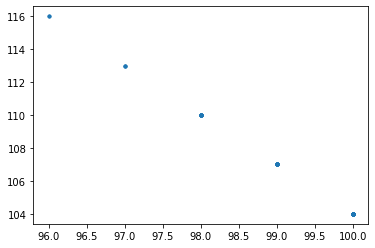

In [40]:
plt.plot(defects, rewards,'.')

In [54]:
%load_ext tensorboard

In [20]:
register_env('MG_env', lambda c: MatrixGameEnv_no_history(player2=TitForTatOrDefect()))

In [38]:
register_env('MG_t4tTR_env', lambda c: MatrixGameEnv(player2=TitForTatThenDefect()))

In [ ]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()


In [25]:
trainer_config_ppo = DEFAULT_CONFIG_PPO.copy()
trainer_config_ppo['num_workers'] = 5
trainer_config_ppo['num_sgd_iter'] = 20
trainer_config_ppo['sgd_minibatch_size'] = 32
# trainer_config_ppo['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
trainer_config_ppo['model']['fcnet_hiddens'] = [256,256,32,8]
# trainer_config_ppo['model']['fcnet_hiddens'] = tune.grid_search([[32,16], [256, 32,16], [256, 256,32,16]])
trainer_config_ppo['model']['use_lstm'] = False
# trainer_config_ppo['lr'] =  tune.grid_search([0.01, 0.001, 0.0001])

# trainer_config_ppo['num_cpus_per_worker'] = 0
trainer_config_ppo['env'] = 'MG_env'

# trainer_config_ppo['num_gpus'] = 0



In [26]:
ray.init(ignore_reinit_error=True)
tune.run(
    "PPO",
    stop={"training_iteration":10},
    
    config=trainer_config_ppo,
#     config={
# #         "num_gpus": 0,
# #         "num_workers": 1,
# #         "lr": tune.grid_search([0.01, 0.001, 0.0001]),
#         "config":trainer_config_ppo
#     },
#     verbose=0
)

2021-07-30 14:08:40,359	INFO worker.py:745 -- Calling ray.init() again after it has already been called.


Trial name,status,loc
PPO_MG_env_0ee9d_00000,PENDING,


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-07-30_14-09-14
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 241.0
  episode_reward_mean: 125.05
  episode_reward_min: 41.0
  episodes_this_iter: 40
  episodes_total: 40
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6617069244384766
          entropy_coeff: 0.0
          kl: 0.03220942243933678
          model: {}
          policy_loss: -0.04173337668180466
          total_loss: 3826.31689453125
          vf_explained_var: -5.879402351638419e-07
          vf_loss: 3826.352294921875
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 10.140.115.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,1,15.9386,4000,125.05,241,41,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-07-30_14-09-33
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 261.0
  episode_reward_mean: 132.45
  episode_reward_min: 36.0
  episodes_this_iter: 40
  episodes_total: 80
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6572600603103638
          entropy_coeff: 0.0
          kl: 0.007395122665911913
          model: {}
          policy_loss: -0.016406115144491196
          total_loss: 4635.94140625
          vf_explained_var: -6.008148289993187e-08
          vf_loss: 4635.9560546875
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 10.140.115.95


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,2,35.2243,8000,132.45,261,36,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-07-30_14-09-51
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 261.0
  episode_reward_mean: 133.12
  episode_reward_min: 36.0
  episodes_this_iter: 40
  episodes_total: 120
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6297959089279175
          entropy_coeff: 0.0
          kl: 0.012444892898201942
          model: {}
          policy_loss: -0.02271566540002823
          total_loss: 3985.2734375
          vf_explained_var: -1.525878978725359e-08
          vf_loss: 3985.292724609375
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 10.140.1

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,3,52.468,12000,133.12,261,36,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-07-30_14-10-09
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 263.0
  episode_reward_mean: 129.4
  episode_reward_min: 32.0
  episodes_this_iter: 40
  episodes_total: 160
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5987403392791748
          entropy_coeff: 0.0
          kl: 0.014305796474218369
          model: {}
          policy_loss: -0.02717319130897522
          total_loss: 3486.262939453125
          vf_explained_var: -4.76837147544984e-09
          vf_loss: 3486.2861328125
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 10.140.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,4,70.5933,16000,129.4,263,32,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-07-30_14-10-26
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 264.0
  episode_reward_mean: 135.26
  episode_reward_min: 26.0
  episodes_this_iter: 40
  episodes_total: 200
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5804921984672546
          entropy_coeff: 0.0
          kl: 0.014489117078483105
          model: {}
          policy_loss: -0.030173804610967636
          total_loss: 4820.7744140625
          vf_explained_var: -8.583068478174027e-09
          vf_loss: 4820.80029296875
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 10.14

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,5,87.6849,20000,135.26,264,26,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-07-30_14-10-44
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 264.0
  episode_reward_mean: 135.64
  episode_reward_min: 26.0
  episodes_this_iter: 40
  episodes_total: 240
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5704641342163086
          entropy_coeff: 0.0
          kl: 0.01529738586395979
          model: {}
          policy_loss: -0.030574331060051918
          total_loss: 3542.36962890625
          vf_explained_var: -8.583068478174027e-09
          vf_loss: 3542.39599609375
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 10.14

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,6,105.6,24000,135.64,264,26,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-07-30_14-10-59
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 266.0
  episode_reward_mean: 142.11
  episode_reward_min: 30.0
  episodes_this_iter: 40
  episodes_total: 280
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5551830530166626
          entropy_coeff: 0.0
          kl: 0.011726786382496357
          model: {}
          policy_loss: -0.02380739152431488
          total_loss: 4389.7998046875
          vf_explained_var: -8.106232129989621e-09
          vf_loss: 4389.8193359375
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 10.140.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,7,120.596,28000,142.11,266,30,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-07-30_14-11-14
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 266.0
  episode_reward_mean: 140.75
  episode_reward_min: 30.0
  episodes_this_iter: 40
  episodes_total: 320
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5371195673942566
          entropy_coeff: 0.0
          kl: 0.014624299481511116
          model: {}
          policy_loss: -0.02725093811750412
          total_loss: 4689.15087890625
          vf_explained_var: -7.1525572131747595e-09
          vf_loss: 4689.17333984375
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 10.1

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,8,136.051,32000,140.75,266,30,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-07-30_14-11-30
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 254.0
  episode_reward_mean: 144.58
  episode_reward_min: 28.0
  episodes_this_iter: 40
  episodes_total: 360
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5342023968696594
          entropy_coeff: 0.0
          kl: 0.01294561568647623
          model: {}
          policy_loss: -0.02708115242421627
          total_loss: 3896.235107421875
          vf_explained_var: -9.536743617033494e-10
          vf_loss: 3896.2578125
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 10.140.11

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,RUNNING,10.140.115.95:80938,9,151.783,36000,144.58,254,28,100


Result for PPO_MG_env_0ee9d_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-07-30_14-11-48
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 252.0
  episode_reward_mean: 141.1
  episode_reward_min: 28.0
  episodes_this_iter: 40
  episodes_total: 400
  experiment_id: a8e539e34582432f84e0398c9b466da6
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5425683259963989
          entropy_coeff: 0.0
          kl: 0.014346797950565815
          model: {}
          policy_loss: -0.028796246275305748
          total_loss: 3406.592041015625
          vf_explained_var: 4.768371808516747e-10
          vf_loss: 3406.61669921875
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 10.14

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,TERMINATED,,10,169.57,40000,141.1,252,28,100


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_0ee9d_00000,TERMINATED,,10,169.57,40000,141.1,252,28,100


2021-07-30 14:11:49,359	INFO tune.py:549 -- Total run time: 189.00 seconds (188.32 seconds for the tuning loop).


In [ ]:
1+1

In [39]:
tune.run(
    "PPO",
    stop={"training_iteration":10},
    config={
        "env": "MG_env",
        "num_gpus": 0,
        "num_workers": 1,
        "lr": tune.grid_search([0.01, 0.001, 0.0001]),\\
    },
)

Trial name,status,loc,lr
PPO_MG_env_1cc7b_00000,PENDING,,0.01
PPO_MG_env_1cc7b_00001,PENDING,,0.001
PPO_MG_env_1cc7b_00002,PENDING,,0.0001


Result for PPO_MG_env_1cc7b_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-07-29_11-40-26
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 240.0
  episode_reward_mean: 120.55
  episode_reward_min: 43.0
  episodes_this_iter: 40
  episodes_total: 40
  experiment_id: 32588f95e5924ff18cc497c7b633b851
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.009999999776482582
          entropy: 0.6639519333839417
          entropy_coeff: 0.0
          kl: 0.03095288760960102
          model: {}
          policy_loss: -0.008811107836663723
          total_loss: 2870.7958984375
          vf_explained_var: 0.04311968386173248
          vf_loss: 2870.798583984375
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.1.21
  

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,1,16.2818,4000,120.55,240,43,100
PPO_MG_env_1cc7b_00001,RUNNING,,0.001,,,,,,,
PPO_MG_env_1cc7b_00002,RUNNING,,0.0001,,,,,,,


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-07-29_11-40-26
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 241.0
  episode_reward_mean: 160.225
  episode_reward_min: 40.0
  episodes_this_iter: 40
  episodes_total: 40
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.0010000000474974513
          entropy: 0.6662601232528687
          entropy_coeff: 0.0
          kl: 0.027907950803637505
          model: {}
          policy_loss: -0.06406012922525406
          total_loss: 4495.77001953125
          vf_explained_var: -3.382659633643925e-05
          vf_loss: 4495.82861328125
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.1.

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,2,32.4774,8000,137.213,260,38,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,1,16.4978,4000,160.225,241,40,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,1,16.5552,4000,140.2,240,47,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-07-29_11-40-43
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 252.0
  episode_reward_mean: 139.2625
  episode_reward_min: 33.0
  episodes_this_iter: 40
  episodes_total: 80
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 0.0010000000474974513
          entropy: 0.6255355477333069
          entropy_coeff: 0.0
          kl: 0.04351194575428963
          model: {}
          policy_loss: -0.09668713063001633
          total_loss: 2530.711669921875
          vf_explained_var: -1.610094477655366e-05
          vf_loss: 2530.795654296875
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 192.168.

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,3,49.0765,12000,143.47,264,38,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,2,32.7367,8000,139.262,252,33,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,2,32.7919,8000,137.7,254,32,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-07-29_11-40-59
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 255.0
  episode_reward_mean: 137.46
  episode_reward_min: 27.0
  episodes_this_iter: 40
  episodes_total: 120
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.44999998807907104
          cur_lr: 0.0010000000474974513
          entropy: 0.5972404479980469
          entropy_coeff: 0.0
          kl: 0.0455242283642292
          model: {}
          policy_loss: -0.11455514281988144
          total_loss: 2629.490234375
          vf_explained_var: -1.1509464457049035e-05
          vf_loss: 2629.58447265625
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,4,65.6383,16000,137.22,264,38,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,3,49.2372,12000,137.46,255,27,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,3,49.3249,12000,127.95,254,29,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-07-29_11-41-16
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 255.0
  episode_reward_mean: 130.76
  episode_reward_min: 25.0
  episodes_this_iter: 40
  episodes_total: 160
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.675000011920929
          cur_lr: 0.0010000000474974513
          entropy: 0.5673757791519165
          entropy_coeff: 0.0
          kl: 0.041409656405448914
          model: {}
          policy_loss: -0.11974494904279709
          total_loss: 2068.830322265625
          vf_explained_var: -3.116746029263595e-06
          vf_loss: 2068.922119140625
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 192.1

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,5,82.4668,20000,144.9,259,40,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,4,65.8122,16000,130.76,255,25,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,4,65.9495,16000,129.31,255,20,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-07-29_11-41-33
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 249.0
  episode_reward_mean: 139.3
  episode_reward_min: 25.0
  episodes_this_iter: 40
  episodes_total: 200
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0010000000474974513
          entropy: 0.5427832007408142
          entropy_coeff: 0.0
          kl: 0.03556763008236885
          model: {}
          policy_loss: -0.12137497216463089
          total_loss: 2354.750732421875
          vf_explained_var: -1.030583575811761e-06
          vf_loss: 2354.835693359375
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.16

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,6,99.0086,24000,160.15,259,44,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,5,82.6015,20000,139.3,249,25,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,5,82.8995,20000,131.7,260,20,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-07-29_11-41-49
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 252.0
  episode_reward_mean: 144.7
  episode_reward_min: 27.0
  episodes_this_iter: 40
  episodes_total: 240
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.5187499523162842
          cur_lr: 0.0010000000474974513
          entropy: 0.5316322445869446
          entropy_coeff: 0.0
          kl: 0.023005222901701927
          model: {}
          policy_loss: -0.10583166033029556
          total_loss: 2242.48779296875
          vf_explained_var: -4.133870561418007e-07
          vf_loss: 2242.558837890625
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 192.16

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,7,115.873,28000,159.45,271,38,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,6,99.0342,24000,144.7,252,27,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,6,99.4359,24000,135.31,271,20,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-07-29_11-42-06
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 252.0
  episode_reward_mean: 143.29
  episode_reward_min: 27.0
  episodes_this_iter: 40
  episodes_total: 280
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.278125047683716
          cur_lr: 0.0010000000474974513
          entropy: 0.5286913514137268
          entropy_coeff: 0.0
          kl: 0.015559675171971321
          model: {}
          policy_loss: -0.08302688598632812
          total_loss: 2034.644287109375
          vf_explained_var: -2.1726854981807264e-07
          vf_loss: 2034.69189453125
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 192.1

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,8,132.627,32000,135.39,278,37,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,7,116.007,28000,143.29,252,27,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,7,116.434,28000,132.56,271,22,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-07-29_11-42-23
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 252.0
  episode_reward_mean: 135.02
  episode_reward_min: 27.0
  episodes_this_iter: 40
  episodes_total: 320
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.278125047683716
          cur_lr: 0.0010000000474974513
          entropy: 0.5110994577407837
          entropy_coeff: 0.0
          kl: 0.016471143811941147
          model: {}
          policy_loss: -0.08449587970972061
          total_loss: 2091.235595703125
          vf_explained_var: -1.0190471755322505e-07
          vf_loss: 2091.282470703125
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 192.

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,RUNNING,192.168.1.21:97175,0.01,9,150.566,36000,140.22,278,37,100
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,8,132.718,32000,135.02,252,27,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,8,133.147,32000,135.95,271,26,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-07-29_11-42-41
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 255.0
  episode_reward_mean: 129.7
  episode_reward_min: 26.0
  episodes_this_iter: 40
  episodes_total: 360
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.278125047683716
          cur_lr: 0.0010000000474974513
          entropy: 0.5103259682655334
          entropy_coeff: 0.0
          kl: 0.015000885352492332
          model: {}
          policy_loss: -0.08032947033643723
          total_loss: 2125.677734375
          vf_explained_var: -7.690921677294682e-08
          vf_loss: 2125.723876953125
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 192.168.1

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00001,RUNNING,192.168.1.21:97178,0.001,9,150.764,36000,129.7,255,26,100
PPO_MG_env_1cc7b_00002,RUNNING,192.168.1.21:97173,0.0001,9,151.171,36000,141.27,254,21,100
PPO_MG_env_1cc7b_00000,TERMINATED,,0.01,10,167.779,40000,147.97,277,33,100


Result for PPO_MG_env_1cc7b_00001:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-07-29_11-42-58
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 255.0
  episode_reward_mean: 138.33
  episode_reward_min: 22.0
  episodes_this_iter: 40
  episodes_total: 400
  experiment_id: 0c6578794e374e0ba692e935dfaa465e
  hostname: coolo-computer
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 2.278125047683716
          cur_lr: 0.0010000000474974513
          entropy: 0.4931609332561493
          entropy_coeff: 0.0
          kl: 0.015556617639958858
          model: {}
          policy_loss: -0.07537218183279037
          total_loss: 2203.83251953125
          vf_explained_var: -4.999099090241543e-08
          vf_loss: 2203.87255859375
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 192.168

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MG_env_1cc7b_00000,TERMINATED,,0.01,10,167.779,40000,147.97,277,33,100
PPO_MG_env_1cc7b_00001,TERMINATED,,0.001,10,168.021,40000,138.33,255,22,100
PPO_MG_env_1cc7b_00002,TERMINATED,,0.0001,10,168.34,40000,134.84,254,21,100


2021-07-29 11:42:59,683	INFO tune.py:549 -- Total run time: 184.33 seconds (183.78 seconds for the tuning loop).


In [37]:
trainer_config_dqn = DEFAULT_CONFIG_DQN.copy()
trainer_config_dqn['num_workers'] = 3
trainer_config_dqn['n_step'] = 3
trainer_config_dqn['noisy'] = True
trainer_config_dqn['v_min'] = -10.
trainer_config_dqn['v_max'] = 10.
# trainer_config_dqn['num_atoms'] = 51

# trainer_config_dqn['model']['fcnet_hiddens'] = [1024, 512,512, 256,256,32,8]
trainer_config_dqn['model']['fcnet_hiddens'] = tune.grid_search([[256,256,32,8],[8]])
# trainer_config_dqn['lr'] = tune.grid_search([0.1,0.01,0.001,0.0001,0.00001, 0.000001])
# trainer_config_dqn['lr'] = tune.grid_search([0.1,0.0001, 0.000001])

trainer_config_dqn['env'] = 'MG_env'
# trainer_config_dqn['num_cpus_per_worker'] = 0


In [38]:
ray.init(ignore_reinit_error=True)
results = tune.run(
    "DQN",
    stop={"training_iteration":2},
    
    config=trainer_config_dqn,
#     config={
# #         "num_gpus": 0,
# #         "num_workers": 1,
# #         "lr": tune.grid_search([0.01, 0.001, 0.0001]),
#         "config":trainer_config_ppo
#     },
    verbose=1
)

2021-07-30 20:52:04,928	INFO tune.py:549 -- Total run time: 26.72 seconds (26.53 seconds for the tuning loop).


In [39]:
results.results.con

{'5a081_00000': {'episode_reward_max': 245.0,
  'episode_reward_min': 36.0,
  'episode_reward_mean': 133.72222222222223,
  'episode_len_mean': 100.0,
  'episode_media': {},
  'episodes_this_iter': 9,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [41.0,
    53.0,
    47.0,
    245.0,
    230.0,
    52.0,
    219.0,
    232.0,
    36.0,
    49.0,
    55.0,
    61.0,
    58.0,
    216.0,
    201.0,
    206.0,
    208.0,
    198.0],
   'episode_lengths': [100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100,
    100]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.23427919125765545,
   'mean_inference_ms': 1.9808622579671733,
   'mean_action_processing_ms': 0.09929705463455807,
   'mean_env_wait_ms': 0.09874352527845993,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'num_healthy_wo